In [1]:
import numpy as np
import matplotlib.pyplot as plt
import funkcjeCpp as cpp
import sklearn.tree
import pyts.classification

In [2]:
np.random.seed(14)

In [3]:
def generujPile(n,mnoz, okres):
    t=[(i%okres)*mnoz for i in range(n)]
    return np.array(t)

In [4]:
 def generujLosowySzeregCzasowy(n, srednia, odch):
    t=np.random.randn(n)*odch+srednia
    t=np.array(np.cumsum(t),dtype=np.float32)
    return t

In [5]:
def generujWzorWzorcowychSzeregowCzasowych(N,n, srednia, odch):
    T=[generujLosowySzeregCzasowy(n,srednia,odch) for i in range(N)]
    for A in T:
        A-=A.mean()
    return np.array(T)

In [6]:
def wprowadzLosoweZaburzenia(wzorce,N,n,std):
    T=[]
    nOrg=wzorce.shape[1]
    zakresPrzesuniecia=max(nOrg-n,0)
    for k in range(wzorce.shape[0]):
        for i in range(N):
            przesuniecie=np.random.randint(low=-zakresPrzesuniecia+1,high=zakresPrzesuniecia)
            if przesuniecie>=0:
                t=wzorce[k,przesuniecie:przesuniecie+n].copy()
            else:
                t=wzorce[k,przesuniecie-n:przesuniecie].copy()
            if t.size==0:
                raise RuntimeError(f"Otrzymano ciąg o zerowej długości. Przesunięcie: {przesuniecie}")
            t+=np.random.randn(t.size)*std
            T.append(np.asarray(t,dtype=np.float32))
    return T

In [5]:
szeregi=[generujLosowySzeregCzasowy(100, 0, 0.3) for i in range(10)]
szeregi=np.array(szeregi)

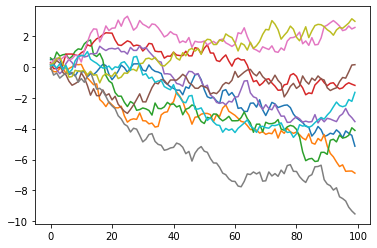

In [6]:
for i in range(szeregi.shape[0]):
    plt.plot(szeregi[i,:])

In [32]:
%%timeit
#ładowanie fragmentów do wektora za pomocą instrukcji ładowania z pamięci + ładowanie instrukcją kształtów
cpp.wygenerujKsztaltyIOdleglosci(szeregi)
#493 µs ± 1.16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

493 µs ± 1.16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
%%timeit
#ładowanie fragmentów do wektora za pomocą instrukcji ładowania z pamięci
cpp.wygenerujKsztaltyIOdleglosci(szeregi)
#529 µs ± 14.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

529 µs ± 14.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
%%timeit
#wersja bez spanów(4ms) + rozwinięcie sumowania redukującego
cpp.wygenerujKsztaltyIOdleglosci(szeregi)
#1.12 ms ± 6.41 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

1.12 ms ± 6.41 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [7]:
%%timeit
#wersja na spanach operacje arytmetyczne ręcznie zwektoryzowane
cpp.wygenerujKsztaltyIOdleglosci(szeregi)
#1.2 ms ± 6.87 µs per loop

1.21 ms ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [7]:
%%timeit
#wersja na spanach auto wektoryzacja
cpp.wygenerujKsztaltyIOdleglosci(szeregi)
#1.81 ms ± 15.8 µs per loop

1.89 ms ± 33.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [35]:
1.89/0.493

3.83367139959432

In [16]:
R=cpp.wygenerujKsztaltyIOdleglosci(szeregi,np.random.randint(0,100000),512)

In [17]:
R[0].shape

(10, 512)

In [24]:
y=np.random.randint(0,10,size=10)

In [27]:
%%timeit
drzewo=sklearn.tree.DecisionTreeClassifier()
drzewo.fit(R[0],y)
poprzedniaDokladnosc=drzewo.score(R[0],y)

1.32 ms ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [7]:
np.random.seed(14)

In [32]:
LiczbaKlas=8
LiczbaSzeregowWKlasie=32
DlugoscWzorca=120
DlugoscSzeregu=100
wzory=generujWzorWzorcowychSzeregowCzasowych(LiczbaKlas,DlugoscWzorca,0,1)
zbiorUczacySzeregow=np.array(wprowadzLosoweZaburzenia(wzory,LiczbaSzeregowWKlasie,DlugoscSzeregu,1))
zbiorUczacySzeregowY=np.repeat(np.arange(LiczbaKlas), LiczbaSzeregowWKlasie)

zbiorTestowySzeregow=np.array(wprowadzLosoweZaburzenia(wzory,LiczbaSzeregowWKlasie,DlugoscSzeregu,1))
zbiorTestowySzeregowY=np.repeat(np.arange(LiczbaKlas), LiczbaSzeregowWKlasie)

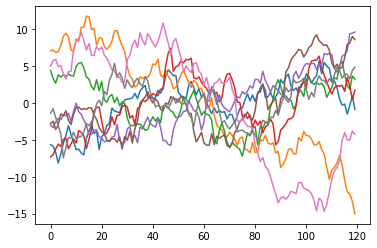

In [33]:
for i in range(wzory.shape[0]):
    plt.plot(wzory[i,:])

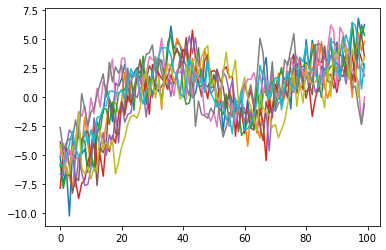

In [34]:
for i in range(10):
    plt.plot(zbiorTestowySzeregow[i,:])

In [37]:
def wybierzKsztalty(szeregi,y,liczbaKsztaltow=20, liczbaLosowanych=128):
    odl,kszt=cpp.wygenerujKsztaltyIOdleglosci(szeregi)
    drzewo=sklearn.tree.DecisionTreeClassifier(max_depth=1)
    drzewo.fit(odl,y)
    indKszt=np.argmax(drzewo.feature_importances_)
    ksztalty=np.empty((liczbaKsztaltow, 16), dtype=np.float32)
    ksztalty[0,:]=kszt[indKszt,:]
    poprzednieOdl=np.empty((szeregi.shape[0], liczbaKsztaltow), dtype=np.float32)
    poprzednieOdl[:,0]=odl[:,indKszt]
    for i in range(1,liczbaKsztaltow):
        odl, kszt=cpp.wygenerujKsztaltyIOdleglosci(szeregi, np.random.randint(0,1000000), liczbaLosowanych)
        cechyDlaDrzewa=np.empty((szeregi.shape[0],i+1))
        cechyDlaDrzewa[:,:i]=poprzednieOdl[:,:i]
        
        najlepszaDokladnosc=0
        indNajlepszegoKsztaltu=None
        for j in range(odl.shape[1]):
            cechyDlaDrzewa[:,-1]=odl[:,j]
            drzewo=sklearn.tree.DecisionTreeClassifier()
            drzewo.fit(cechyDlaDrzewa,y)
            wynik=drzewo.score(cechyDlaDrzewa,y)
            if najlepszaDokladnosc<wynik:
                najlepszaDokladnosc=wynik
                indNajlepszegoKsztaltu=j
        ksztalty[i,:]=kszt[indNajlepszegoKsztaltu,:]
        poprzednieOdl[:,i]=odl[:,indNajlepszegoKsztaltu]
    return poprzednieOdl, ksztalty

In [39]:
%%timeit
odl, kszt=wybierzKsztalty(zbiorUczacySzeregow, zbiorUczacySzeregowY)

4.57 s ± 98.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
odl, kszt=wybierzKsztalty(zbiorUczacySzeregow, zbiorUczacySzeregowY,liczbaKsztaltow=32)

drzewo=sklearn.tree.DecisionTreeClassifier()
drzewo.fit(odl,zbiorUczacySzeregowY)

odlTest=cpp.odleglosciMiedzyKsztaltamiISzeregami(zbiorTestowySzeregow, kszt)

poprzedniaDokladnosc=drzewo.score(odlTest,zbiorTestowySzeregowY)
print(poprzedniaDokladnosc)

0.953125


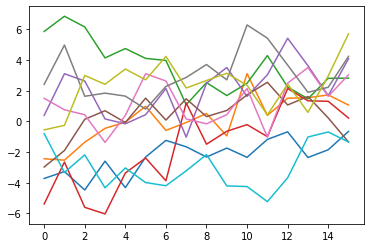

In [36]:
for i in range(10):
    plt.plot(kszt[i,:])

In [37]:
import graphviz 
dot_data = sklearn.tree.export_graphviz(drzewo, out_file=None) 
graph = graphviz.Source(dot_data) 

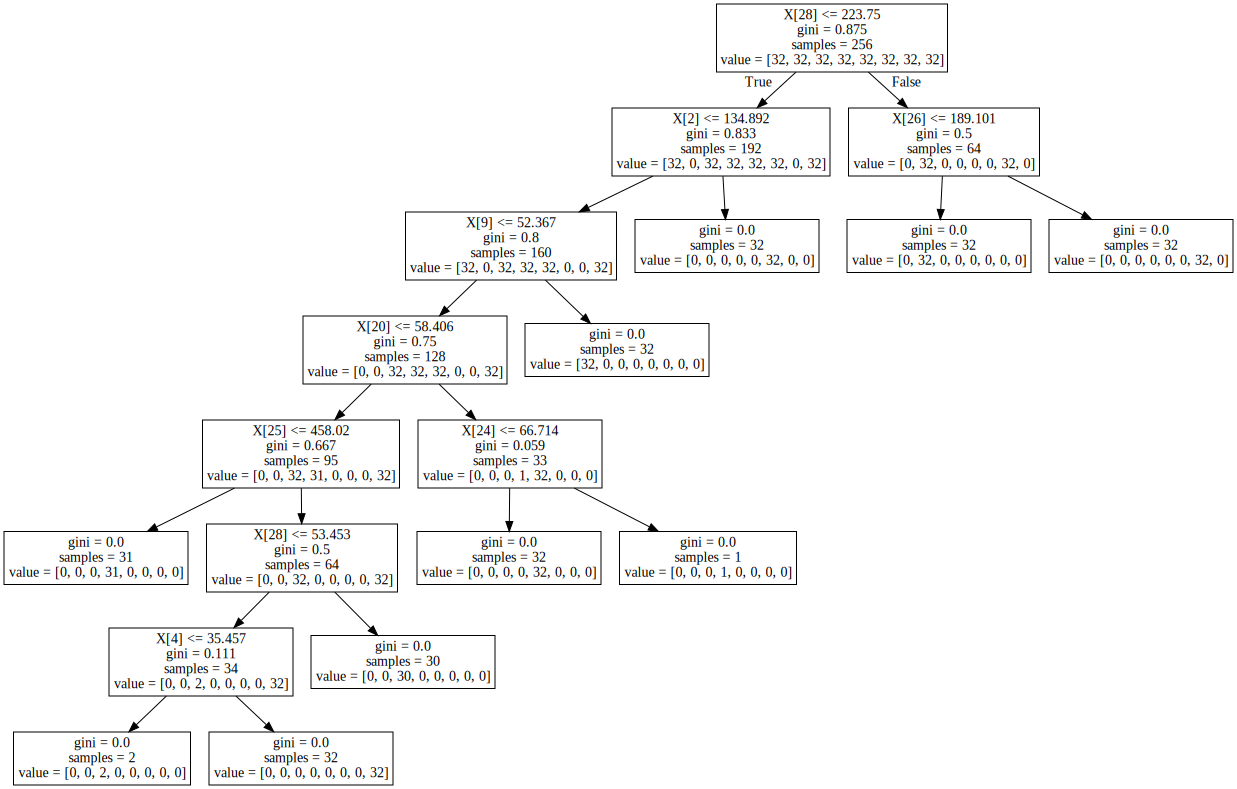

In [38]:
graph

In [49]:
%%time
model=pyts.classification.LearningShapelets(tol=0.001, max_iter=1000)
model.fit(zbiorUczacySzeregow, zbiorUczacySzeregowY)

/usr/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7], y=[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


CPU times: user 41min 25s, sys: 1min 22s, total: 42min 47s
Wall time: 19min 25s


/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


LearningShapelets()

In [50]:
model.score(odlTest,zbiorTestowySzeregowY)

0.14453125

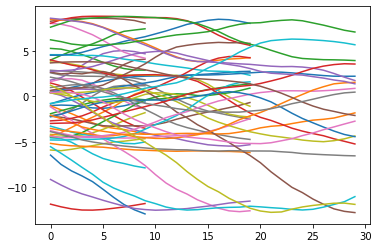

In [60]:
for i in model.shapelets_[0,:]:
    plt.plot(i)

# Zad 2

In [3]:
import pyts.datasets

In [4]:
gun=pyts.datasets.load_gunpoint()

In [5]:
gunTrain=np.array(gun['data_train'], dtype=np.float32)
gunTrainY=gun["target_train"]

gunTest=np.array(gun["data_test"], dtype=np.float32)
gunTestY=gun["target_test"]

In [71]:
odl, kszt=wybierzKsztalty(gunTrain, gunTrainY,liczbaKsztaltow=32)

drzewo=sklearn.tree.DecisionTreeClassifier()
drzewo.fit(odl,gunTrainY)

odlTest=cpp.odleglosciMiedzyKsztaltamiISzeregami(gunTest, kszt)

poprzedniaDokladnosc=drzewo.score(odlTest,gunTestY)
print(poprzedniaDokladnosc)

0.8933333333333333


In [41]:
odl, kszt=wybierzKsztalty(gunTrain, gunTrainY,liczbaKsztaltow=64, liczbaLosowanych=1024)

drzewo=sklearn.tree.DecisionTreeClassifier()
drzewo.fit(odl,gunTrainY)

odlTest=cpp.odleglosciMiedzyKsztaltamiISzeregami(gunTest, kszt)

poprzedniaDokladnosc=drzewo.score(odlTest,gunTestY)
print(poprzedniaDokladnosc)

0.8266666666666667


In [25]:
%%time
gunModel=pyts.classification.LearningShapelets(tol=0.0000001, max_iter=2000, shapelet_scale=3, 
                                               n_shapelets_per_size=0.2, learning_rate=10)
gunModel.fit(gunTrain, gunTrainY)

/usr/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1 2], y=[2 2 1 1 2 2 2 2 2 1 1 1 1 1 2 1 2 2 1 2 1 1 1 2 1 2 1 1 2 1 1 2 2 1 2 1 2
 2 2 2 2 1 1 1 2 2 1 2 1 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


CPU times: user 19min 21s, sys: 721 ms, total: 19min 22s
Wall time: 19min 15s


/home/kuba/.local/lib/python3.9/site-packages/pyts/classification/learning_shapelets.py:580: ConvergenceWarning: Maximum number of iterations reached without converging. Increase the maximum number of iterations.
  warnings.warn('Maximum number of iterations reached without '
/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


LearningShapelets(learning_rate=10, max_iter=2000, tol=1e-07)

In [26]:
gunModel.score(gunTest,gunTestY)

0.94

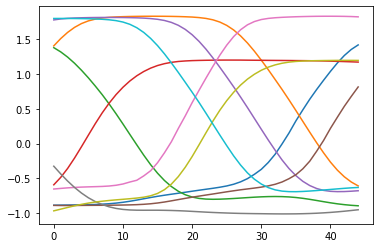

In [30]:
for i in gunModel.shapelets_[0,70:80]:
    plt.plot(i)

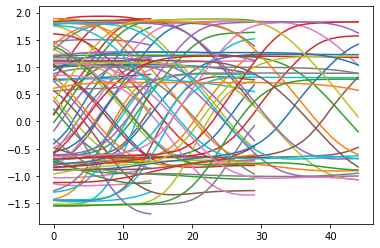

In [31]:
for i in gunModel.shapelets_[0,:]:
    plt.plot(i)